## CLustering & Modeling with LLMs

In [7]:
import ipywidgets as widgets

In [8]:
import warnings
warnings.filterwarnings("ignore")

import transformers
transformers.logging.set_verbosity_error()

In [9]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [10]:
import logging
logging.getLogger("huggingface_hub.repocard").setLevel(logging.ERROR)

The `heegyu/news-category-dataset` is a text classification dataset built from HuffPost news headlines and associated metadata, adapted from the News Category Dataset. It contains about 210k English headlines published between 2012 and 2022, each labeled with one of 40+ fine-grained news categories such as politics, entertainment, wellness, business, and travel. For each item, the dataset typically provides the headline, short description, publication date, authors, link to the original article, and the target category, making it a convenient benchmark for news topic classification, content tagging, and broader NLP tasks like semantic analysis or style studies on real-world journalistic text.

In [11]:
from datasets import load_dataset

# Load the training split of the news category dataset from Hugging Face
dataset = load_dataset("heegyu/news-category-dataset", split="train")

# Shuffle the dataset for randomness and select a subset of 15,000 samples
# (useful to reduce computation time while keeping diversity)
dataset_small = dataset.shuffle(seed=42).select(range(15_000))

# Build the document texts by combining headline and short description
# If the short description is missing, keep only the headline
docs = [
    f"{h}. {d}" if d is not None else h
    for h, d in zip(dataset_small["headline"], dataset_small["short_description"])
]

titles = dataset_small["headline"]

### Pipeline for Text Clustering

**Text clustering** is a powerful technique for uncovering both expected and previously unseen structure in text corpora. It offers an intuitive way to understand classification-like behaviors while exposing the underlying complexity of semantic organization, making it much more than a simple exploratory data analysis trick.

A commonly used pipeline for text clustering comprises three main stages:

1. Convert documents into numerical vector representations using an embedding model.

2. Apply a dimensionality reduction method to compress and denoise these embeddings.

3. Run a clustering algorithm to group semantically related documents based on their reduced representations.

#### Embedding Documents

Selecting **embedding models** that are specifically optimized for semantic similarity is crucial for clustering, since the goal is to group documents by meaning rather than surface form. At the time of writing, the majority of widely used embedding models are already designed with semantic similarity tasks in mind, which makes them well suited for clustering applications.

In [12]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence embedding model
embedding_model = SentenceTransformer("thenlper/gte-small")

# Encode each document into a fixed-size vector representation
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [13]:
# Dimensions of the embeddings
embeddings.shape

(15000, 384)

#### Reducing the Dimensionality of Embeddings

Before clustering embeddings, it is necessary to tackle their high dimensionality. As dimensionality increases, the space of possible values grows exponentially, making it increasingly difficult to explore relevant subspaces and detect structure. In such settings, many clustering algorithms struggle to discover meaningful groups. **Dimensionality reduction** mitigates this issue by compressing the representation into a lower-dimensional space while preserving the most important characteristics of the data.

In [14]:
from umap import UMAP

# Initialize UMAP for dimensionality reduction of sentence embeddings
umap_model = UMAP(
    n_components=10,        # Target dimensionality (balance between information and efficiency)
    n_neighbors=15,         # Controls local vs global structure preservation
    min_dist=0.0,           # Allows tighter clustering of points
    metric="cosine",        # Appropriate for normalized semantic embeddings
    random_state=42,        # Ensures reproducible results
    low_memory=True,        # Reduces memory usage for large datasets
    verbose=True,           # Displays progress information
)

# Fit UMAP on the embeddings and transform them to the reduced space
reduced_embeddings = umap_model.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_jobs=1, random_state=42, verbose=True)
Mon Dec 22 12:37:46 2025 Construct fuzzy simplicial set
Mon Dec 22 12:37:46 2025 Finding Nearest Neighbors
Mon Dec 22 12:37:46 2025 Building RP forest with 11 trees
Mon Dec 22 12:37:52 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	Stopping threshold met -- exiting after 7 iterations
Mon Dec 22 12:38:02 2025 Finished Nearest Neighbor Search
Mon Dec 22 12:38:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Dec 22 12:38:13 2025 Finished embedding


### Cluster & Reduced Embeddings

Once the embeddings have been projected into a lower-dimensional space, we can proceed to discover groups of related documents. In this workflow, the **clustering** step relies on HDBSCAN *(Hierarchical Density-Based Spatial Clustering)*, which has the advantage of inferring the number of clusters automatically while also handling noisy or outlier points in a robust way.

In [15]:
from hdbscan import HDBSCAN
import numpy as np

# Initialize HDBSCAN for clustering the UMAP-reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=20,             # Minimum size of clusters to be considered valid
    min_samples=10,                  # Minimum number of samples in a neighborhood for a point to be considered core
    metric="euclidean",              # Distance metric used for clustering
    cluster_selection_method="eom",  # Use Excess of Mass method for selecting clusters
    prediction_data=True,            # Enable prediction of cluster membership for new points later
)

# Fit HDBSCAN on the reduced embeddings and get cluster labels
# Label -1 indicates noise/outliers
clusters = hdbscan_model.fit_predict(reduced_embeddings)

# Compute unique clusters and count clusters excluding noise
unique_clusters = set(clusters)
n_clusters = len(unique_clusters - {-1})  # Exclude -1 which represents noise/outliers

# Count number of points classified as noise/outliers
n_noise = np.sum(clusters == -1)

# Print summary statistics
print(f"Number of clusters: {n_clusters}")
print(f"Number of outliers: {n_noise}")

Number of clusters: 101
Number of outliers: 6554


#### Inspecting the Clusters

With the clusters in hand, the next step is to inspect their contents. By examining the individual documents assigned to a given cluster, we can infer the dominant topics or themes that the clustering process has uncovered.

In [16]:
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
  print(list(docs)[index][:300] + "... \n")

Top Five HuffPost Science Stories This Week, March 3-8. From one of the oldest-known preserved human dissections, to a "knot" tied with water, the week was filled with interesting... 

HuffPost Headline Quiz: April 28 to May 4. Ready for a challenge?... 

HuffPost Rise: All The News You Need To Know On November 25th. Here's all the news you need to know to start your morning.... 



Next, we project the embeddings into two dimensions, allowing us to visualize them and obtain an initial, intuitive sense of the cluster structure.

In [17]:
import pandas as pd
from umap import UMAP

# Reduce embeddings to 2D for visualization purposes
umap_vis = UMAP(
    n_components=2,    # 2D for plotting
    min_dist=0.0,      # Allows points in the same cluster to be closer together
    metric="cosine",   # Appropriate for semantic embeddings
    random_state=42,   # Ensures reproducibility
)
reduced_embeddings_2d = umap_vis.fit_transform(embeddings)

# Create the main DataFrame for visualization and analysis
df = pd.DataFrame(reduced_embeddings_2d, columns=["x", "y"])
df["title"] = titles
df["cluster"] = clusters.astype(int)
df["cluster_str"] = df["cluster"].astype(str)

# Separate data into clustered points and outliers
clusters_df = df[df["cluster"] != -1].copy()
outliers_df = df[df["cluster"] == -1].copy()

#### Cluster Visulaization

Now we plot the clusters in 2D with matplotlib, which is far more convenient than trying to visualize all original dimensions. Outliers are shown in white, and each cluster is assigned a distinct color to clearly reveal the grouping structure.

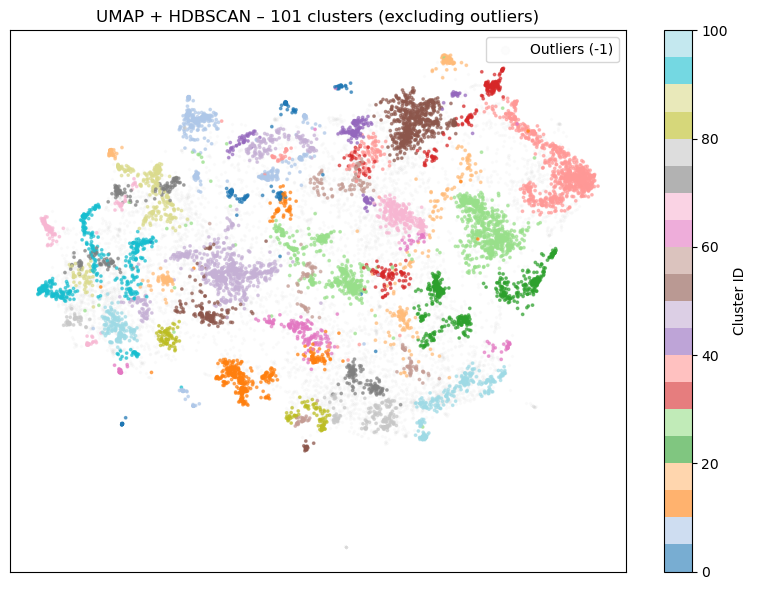

In [18]:
import matplotlib.pyplot as plt

# Get the unique cluster IDs and count of clusters (excluding outliers)
unique_clusters = sorted(clusters_df["cluster"].unique())
n_clusters = len(unique_clusters)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot outliers in light grey at the background
ax.scatter(
    outliers_df["x"],
    outliers_df["y"],
    alpha=0.05,       # Very transparent to keep focus on clusters
    s=2,              # Small marker size for outliers
    c="lightgrey",    # Color for noise points
    label="Outliers (-1)",
)

# Plot clustered points with different colors
scatter = ax.scatter(
    clusters_df["x"],
    clusters_df["y"],
    c=clusters_df["cluster"],  # Color by cluster ID
    alpha=0.6,                 # Semi-transparent to reduce overplotting
    s=3,                        # Marker size
    cmap="tab20",               # Discrete colormap for clusters
)

# Optional: add a colorbar to show cluster IDs
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Cluster ID")

# Remove axis ticks for a cleaner plot
ax.set_xticks([])
ax.set_yticks([])

# Add title and legend
ax.set_title(f"UMAP + HDBSCAN – {n_clusters} clusters (excluding outliers)")
ax.legend(markerscale=4, loc="best")  # Legend with larger marker for clarity

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### From Clustering to Topic Modeling

While clustering groups similar documents together, **topic modeling** adds an extra layer by extracting representative keywords that summarize each cluster. This turns purely numeric clusters into human-readable topics. In this workflow, [BERTopic](https://github.com/MaartenGr/BERTopic) is used for topic modeling, extending the three-step clustering pipeline with a topic representation step: it relies on class-based TF–IDF *(c-TF–IDF)* to derive the most salient keywords per cluster, yielding interpretable topic labels. The framework is highly modular, allowing custom choices for the embedding model, dimensionality reduction method, and clustering algorithm.

In [19]:
from bertopic import BERTopic

# Initialize a BERTopic model using custom UMAP and HDBSCAN model
topic_model = BERTopic(
    embedding_model=embedding_model,  # Use the precomputed sentence embeddings
    umap_model=umap_model,            # Custom UMAP model for dimensionality reduction
    hdbscan_model=hdbscan_model,      # Custom HDBSCAN model for clustering
    n_gram_range=(1, 2),              # Include unigrams and bigrams in topics
    min_topic_size=20,                 # Minimum number of documents to form a topic
    calculate_probabilities=True,      # Compute topic probabilities for each document
    verbose=True,                      # Print progress and info during fitting
)

# Fit BERTopic to the documents and embeddings
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-12-22 12:38:29,436 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_jobs=1, random_state=42, verbose=True)
Mon Dec 22 12:38:29 2025 Construct fuzzy simplicial set
Mon Dec 22 12:38:29 2025 Finding Nearest Neighbors
Mon Dec 22 12:38:29 2025 Building RP forest with 11 trees
Mon Dec 22 12:38:29 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	Stopping threshold met -- exiting after 7 iterations
Mon Dec 22 12:38:31 2025 Finished Nearest Neighbor Search
Mon Dec 22 12:38:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Dec 22 12:38:39 2025 Finished embedding


2025-12-22 12:38:39,126 - BERTopic - Dimensionality - Completed ✓
2025-12-22 12:38:39,127 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-22 12:38:43,098 - BERTopic - Cluster - Completed ✓
2025-12-22 12:38:43,103 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-22 12:38:44,770 - BERTopic - Representation - Completed ✓


In [20]:
# Get a summary of all discovered topics
# Includes topic IDs, sizes (number of documents), and representative words
topic_info = topic_model.get_topic_info()
display(topic_info)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6554,-1_the_to_of_and,"[the, to, of, and, in, for, is, on, it, that]","[Dear Cancer: It's Not Me, It's You. Dear Canc..."
1,0,683,0_travel_the_in_and,"[travel, the, in, and, of, to, you, for, is, on]",[The World Wildlife Fund's Eco-Friendly Travel...
2,1,560,1_food_recipes_you_recipe,"[food, recipes, you, recipe, and, to, eat, the...","[Angel Food Cake Recipes, Plus Delicious Thing..."
3,2,520,2_you_your_we_to,"[you, your, we, to, life, and, of, that, our, is]",[4 Tips to Ensure That You Celebrate Your Wond...
4,3,510,3_police_in_shooting_officer,"[police, in, shooting, officer, cops, of, ferg...","[Sunday Roundup. This week, the nation's eyes ..."
...,...,...,...,...,...
97,96,22,96_transgender_trans_the trans_gender,"[transgender, trans, the trans, gender, we, as...",[Sober Trans Housing. Besides struggling to ac...
98,97,22,97_huffpost rise_rise_huffpost_newsbrief,"[huffpost rise, rise, huffpost, newsbrief, mor...",[HuffPost Rise: What You Need To Know On March...
99,98,22,98_hiv_aids_hiv aids_of hiv,"[hiv, aids, hiv aids, of hiv, the hiv, hiv tes...",[The National HIV/AIDS Strategy at Two: The Be...
100,99,21,99_smoking_quit_tobacco_smokers,"[smoking, quit, tobacco, smokers, cigarettes, ...",[Most Smokers Have Tried To Quit Smoking Befor...


In [21]:
# Retrieve the most representative words for topic ID 0
# Each topic is a list of tuples (word, importance_score)
topic_0_words = topic_model.get_topic(0)
display(topic_0_words)

[('travel', np.float64(0.012254515868630304)),
 ('the', np.float64(0.009972214933471918)),
 ('in', np.float64(0.007992880276481129)),
 ('and', np.float64(0.007674877596842631)),
 ('of', np.float64(0.00763271228005402)),
 ('to', np.float64(0.007536871550415675)),
 ('you', np.float64(0.007317705007840406)),
 ('for', np.float64(0.005991430843108943)),
 ('is', np.float64(0.0057688430175137926)),
 ('on', np.float64(0.0057610332235375735))]

In [22]:
# Find topics that are most related to the query word "healthcare"
# Returns a list of topic IDs and their similarity scores
related_topics = topic_model.find_topics("healthcare")
display(related_topics)

([57, 20, 19, 98, 31],
 [np.float32(0.9112772),
  np.float32(0.8879141),
  np.float32(0.8768785),
  np.float32(0.87164533),
  np.float32(0.86704063)])

In [23]:
# Retrieve the most representative words for topic ID 55
# Each topic is a list of tuples (word, importance_score)
topic_55_words = topic_model.get_topic(55)
display(topic_55_words)

[('news', np.float64(0.03620813953281481)),
 ('york times', np.float64(0.015239924528684898)),
 ('new york', np.float64(0.014257970149791533)),
 ('york', np.float64(0.01421170422132869)),
 ('the news', np.float64(0.01373137295375849)),
 ('the paper', np.float64(0.013300925130752215)),
 ('editor', np.float64(0.012551267650886811)),
 ('times', np.float64(0.012517596889577102)),
 ('paper', np.float64(0.011771247610215462)),
 ('new', np.float64(0.011188144617236903))]

#### Interactive Visualization

In [24]:
# Visualize documents in a 2D projection using BERTopic
fig = topic_model.visualize_documents(
    list(titles),                # Document labels (headlines) for hover tooltips
    reduced_embeddings=reduced_embeddings,  # Use UMAP-reduced embeddings for positioning
    width=1200,                  # Figure width in pixels
    hide_annotations=True        # Hide individual topic labels for clarity
)

# Customize layout for better readability
fig.update_layout(
    title="BERTopic – Document Projection",  # Plot title
    font=dict(size=16),                       # Font size for text
    margin=dict(l=40, r=40, t=80, b=40),     # Margins around the plot
    legend_title_text="Topics",               # Title for the legend
    template="plotly_white"                   # Use a clean white background template
)

fig.show()

In [25]:
# Visualize the distribution of topics as a bar chart
fig_barchart = topic_model.visualize_barchart()

# Customize layout for better readability
fig_barchart.update_layout(
    title="Topic Distribution",              # Plot title
    font=dict(size=16),                       # Font size for text
    margin=dict(l=40, r=40, t=80, b=40),     # Margins around the plot
    template="plotly_white"                   # Clean white background template
)

fig_barchart.show()

In [26]:
# Visualize the similarity between topics as a heatmap
fig_heatmap = topic_model.visualize_heatmap(n_clusters=30)  # Cluster topics into 30 groups for clarity

# Customize layout for readability
fig_heatmap.update_layout(
    title="Topic Similarity Heatmap",        # Plot title
    font=dict(size=16),                       # Font size for text
    margin=dict(l=60, r=40, t=80, b=40),     # Margins around the plot
    template="plotly_white"                   # Clean white background template
)

fig_heatmap.show()

In [27]:
# Visualize the hierarchical relationships between topics
fig_hierarchy = topic_model.visualize_hierarchy()

# Customize layout for readability
fig_hierarchy.update_layout(
    title="Topic Hierarchy",                  # Plot title
    font=dict(size=16),                        # Font size for text
    margin=dict(l=40, r=40, t=80, b=40),      # Margins around the plot
    template="plotly_white"                    # Clean white background template
)

fig_hierarchy.show()

### Representation Models

In the following examples, we will refine the topic representations after training the model, which enables rapid and flexible iteration.

In [28]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Initialize a KeyBERT-inspired representation model
representation_model = KeyBERTInspired()

# Initialize a BERTopic model with custom embedding, UMAP, HDBSCAN, and representation models
topic_model = BERTopic(
    embedding_model=embedding_model,         # Use precomputed sentence embeddings
    umap_model=umap_model,                   # Custom UMAP model for dimensionality reduction
    hdbscan_model=hdbscan_model,             # Custom HDBSCAN model for clustering
    representation_model=representation_model,  # Use KeyBERT-inspired topic representation
    n_gram_range=(1, 2),                     # Include unigrams and bigrams in topic words
    min_topic_size=20,                        # Minimum number of documents to form a topic
    calculate_probabilities=True,             # Compute topic probabilities for each document
    verbose=True,                             # Print progress and info during fitting
)

# Fit BERTopic to the documents and embeddings
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-12-22 12:38:48,775 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_jobs=1, random_state=42, verbose=True)
Mon Dec 22 12:38:48 2025 Construct fuzzy simplicial set
Mon Dec 22 12:38:48 2025 Finding Nearest Neighbors
Mon Dec 22 12:38:48 2025 Building RP forest with 11 trees
Mon Dec 22 12:38:49 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	Stopping threshold met -- exiting after 7 iterations
Mon Dec 22 12:38:50 2025 Finished Nearest Neighbor Search
Mon Dec 22 12:38:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


2025-12-22 12:38:58,511 - BERTopic - Dimensionality - Completed ✓
2025-12-22 12:38:58,514 - BERTopic - Cluster - Start clustering the reduced embeddings


Mon Dec 22 12:38:58 2025 Finished embedding


2025-12-22 12:39:02,550 - BERTopic - Cluster - Completed ✓
2025-12-22 12:39:02,554 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-22 12:39:17,820 - BERTopic - Representation - Completed ✓


To use representation models, we first duplicate the trained topic model so that we can clearly compare its behavior with and without a representation model.

In [29]:
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [30]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

#### KeyBERTInspired

This representation model uses embeddings to identify the keywords that are closest to the topic’s overall semantic meaning, producing more coherent and representative topic descriptions.

In [31]:
from bertopic.representation import KeyBERTInspired

# Initialize a KeyBERT-inspired representation model
representation_model = KeyBERTInspired()

# Update the topics in the existing BERTopic model using the new representation model
topic_model.update_topics(docs, representation_model=representation_model)

# Compare the updated topics with the original topics
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,photos | world | and | by | the world,travel | traveling | travelers | traveler | to...
1,1,things | some | this | sweet | these,recipes | recipe | food | recipes that | foods
2,2,world | they | out | daily | life,your life | yourself | own | change | you
3,3,in ferguson | ferguson | murder | killed | found,in ferguson | ferguson | racism | cops | protests
4,4,who | they | more | all | some,animal photos | animals | dogs | animal | pets


#### Maximal Marginal Relevance *(MMR)*

**Maximal Marginal Relevance** selects keywords by trading off between relevance and diversity. The diversity parameter (ranging from 0 to 1) controls this balance: higher values yield more varied keywords, whereas lower values favor highly relevant ones.

In [32]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(docs, representation_model=representation_model)

topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,photos | world | and | by | the world,travel | of the | airlines | world | photos
1,1,things | some | this | sweet | these,recipes | to | eat | cake | make
2,2,world | they | out | daily | life,we | life | of | can | how
3,3,in ferguson | ferguson | murder | killed | found,officer | cops | of | ferguson | killed
4,4,who | they | more | all | some,animal | cats | the | bear | wild


#### Text Generation

Instead of relying solely on keywords, we can use **Large Language Models** *(LLMs)* to generate natural language descriptions for each topic. This yields more readable, contextually rich labels that better capture the nuance of the underlying clusters.

In [33]:
from transformers import pipeline, AutoTokenizer
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

generator = pipeline(
    "text2text-generation",
    model="google/flan-t5-small",
    truncation=True,
    max_length=512
)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

representation_model = TextGeneration(
    generator,
    prompt=prompt,
    doc_length=8,
    tokenizer=tokenizer,
    nr_docs=5
)

topic_model.update_topics(docs, representation_model=representation_model)
topic_differences(topic_model, original_topics)

100%|██████████| 102/102 [03:49<00:00,  2.25s/it]


,Topic,Original,Updated
0,0,photos | world | and | by | the world,travel | | | |
1,1,things | some | this | sweet | these,What's the best cheese for a - 5 madly delicio...
2,2,world | they | out | daily | life,- How avoidance will make you fearful - New Vi...
3,3,in ferguson | ferguson | murder | killed | found,"police officer, police officer, police officer..."
4,4,who | they | more | all | some,animal photos of the week | | | |


#### Groq

Now let’s generate topic labels using Groq, and this time the labeling will be done automatically. Our task is to implement a function that calls the Groq API to produce clearer, more human-readable labels for the topics discovered by BERTopic.

In [ ]:
import os
import time
import random
from typing import Dict, List

from groq import Groq

# -----------------------------
# Configuration
# -----------------------------
MODEL_NAME = "meta-llama/llama-4-scout-17b-16e-instruct"  # LLM model to use
MAX_RETRIES = 3        # Max number of retries for API calls
MAX_DOCS = 5           # Max representative documents per topic
MAX_KEYWORDS = 10      # Max keywords to include in the prompt
SLEEP_RANGE = (0.5, 1.0)  # Random sleep to avoid rate limits

# Limits to stay under ~512 tokens in the prompt
MAX_WORDS_PER_DOC = 80        # Max words per representative doc
MAX_TOTAL_DOC_WORDS = 300     # Max cumulative words across all docs

# -----------------------------
# Prompt template
# -----------------------------
PROMPT_TEMPLATE = """You are given a topic extracted from a document collection.

Documents:
{documents}

Keywords:
{keywords}

Task:
Generate a short, clear topic label (2–5 words maximum).

Rules:
- Do NOT add explanations
- Do NOT add punctuation
- Do NOT repeat the word "topic"

Return only the label text.
"""

# -----------------------------
# Helper functions
# -----------------------------
def _clean_llm_label(text: str) -> str:
    """
    Extract a clean topic label from LLM output.
    """
    text = text.strip()

    # Handle outputs like "Topic: Something"
    lower = text.lower()
    if "topic:" in lower:
        pos = lower.find("topic:")
        text = text[pos + 6:]

    # Keep only the first line
    return text.split("\n")[0].strip()


def _truncate_text(text: str, max_words: int) -> str:
    """
    Truncate text to at most `max_words` whitespace-separated tokens.
    """
    tokens = text.split()
    if len(tokens) <= max_words:
        return text
    return " ".join(tokens[:max_words])


def _build_documents_block(rep_docs: List[str]) -> str:
    """
    Concatenate representative documents while respecting max length limits
    to stay within the LLM token window.
    """
    truncated_docs = [_truncate_text(d, MAX_WORDS_PER_DOC) for d in rep_docs[:MAX_DOCS]]

    all_tokens: List[str] = []
    for d in truncated_docs:
        toks = d.split()
        if len(all_tokens) + len(toks) > MAX_TOTAL_DOC_WORDS:
            break  # Stop before exceeding global word limit
        all_tokens.extend(toks)

    return " ".join(all_tokens)

# -----------------------------
# Main function
# -----------------------------
def update_topics_with_groq(topic_model, documents, model: str = MODEL_NAME):
    """
    Update BERTopic topic labels using Groq LLM,
    truncating prompts to stay under ~512 tokens.
    """

    # Use API key from environment
    api_key = os.getenv("GROQ_API_KEY")
    if not api_key:
        raise RuntimeError("GROQ_API_KEY environment variable not set")

    client = Groq(api_key=api_key)

    topics = topic_model.get_topics()
    updated_labels: Dict[int, str] = {}

    for topic_id, topic_words in topics.items():

        # Skip outliers
        if topic_id == -1:
            continue

        # -----------------------------
        # Representative documents (truncated)
        # -----------------------------
        rep_docs = topic_model.get_representative_docs(topic_id)
        docs_text = _build_documents_block(rep_docs)

        # -----------------------------
        # Keywords (limit to top N)
        # -----------------------------
        keywords = [word for word, _ in topic_words[:MAX_KEYWORDS]]
        keywords_text = ", ".join(keywords)

        # Build the prompt
        prompt = PROMPT_TEMPLATE.format(documents=docs_text, keywords=keywords_text)

        label = None

        # Retry logic for robustness
        for attempt in range(1, MAX_RETRIES + 1):
            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You generate concise topic labels."},
                        {"role": "user", "content": prompt},
                    ],
                    temperature=0,
                    max_tokens=32,
                )

                raw_label = response.choices[0].message.content
                label = _clean_llm_label(raw_label)

                # Polite rate-limit
                time.sleep(random.uniform(*SLEEP_RANGE))
                break

            except Exception as e:
                print(f"[Topic {topic_id}] Attempt {attempt} failed: {e}")
                if attempt < MAX_RETRIES:
                    wait = 2 ** (attempt - 1)
                    time.sleep(wait)
                else:
                    label = f"Topic {topic_id}"

        # Save updated label
        updated_labels[topic_id] = label
        print(f"[Topic {topic_id}] → {label}")

    # Apply updated labels to BERTopic model
    topic_model.set_topic_labels(updated_labels)
    return topic_model

In [35]:
topic_model = update_topics_with_groq(topic_model, docs)

[Topic 0] → Eco Friendly Travel Tips
[Topic 1] → Food and Dessert Recipes
[Topic 2] → Personal Growth and Empowerment
[Topic 3] → Police Militarization and Protests
[Topic 4] → Animal Photos Of Week
[Topic 5] → Climate Change Impacts Health
[Topic 6] → NFL Coaching Changes Sports
[Topic 7] → Home Design and Decor
[Topic 8] → Motherhood and Personal Growth
[Topic 9] → Weight Loss Success Stories
[Topic 10] → Donald Trump Presidential Style
[Topic 11] → Dating After Divorce Tips
[Topic 12] → LGBTQ Health and Wellness
[Topic 13] → Trump Immigration Policy Protests
[Topic 14] → Putin and Ukraine Conflict
[Topic 15] → LGBT Rights and Marriage
[Topic 16] → Fitness Workout Routines
[Topic 17] → Sleep Apnea Awareness
[Topic 18] → Bernie Sanders Campaign Updates
[Topic 19] → Ebola Virus Update US
[Topic 20] → Obamacare Repeal Efforts
[Topic 21] → Wedding Planning Tips
[Topic 22] → Worst Run American Cities
[Topic 23] → Mental Health Stigma Issues
[Topic 24] → Holiday Stress Management Tips
[Top

In [36]:
# Get a summary of all discovered topics in the BERTopic model
# Includes topic IDs, sizes (number of documents), and representative words
topic_info = topic_model.get_topic_info()
display(topic_info)

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,6554,-1_- Best Parenting Tweets: What Mom - Dear Ca...,-1_- Best Parenting Tweets: What Mom - Dear Ca...,[- Best Parenting Tweets: What Mom - Dear Canc...,"[Dear Cancer: It's Not Me, It's You. Dear Canc..."
1,0,683,0_travel___,Eco Friendly Travel Tips,"[travel, , , , , , , , , ]",[The World Wildlife Fund's Eco-Friendly Travel...
2,1,560,1_What's the best cheese for a - 5 madly delic...,Food and Dessert Recipes,[What's the best cheese for a - 5 madly delici...,"[Angel Food Cake Recipes, Plus Delicious Thing..."
3,2,520,2_- How avoidance will make you fearful - New ...,Personal Growth and Empowerment,[- How avoidance will make you fearful - New V...,[4 Tips to Ensure That You Celebrate Your Wond...
4,3,510,"3_police officer, police officer, police offic...",Police Militarization and Protests,"[police officer, police officer, police office...","[Sunday Roundup. This week, the nation's eyes ..."
...,...,...,...,...,...,...
97,96,22,"96_ENDA Matters to the - What Can We Do Now, A...",Transgender Rights and Issues,"[ENDA Matters to the - What Can We Do Now, Aft...",[Sober Trans Housing. Besides struggling to ac...
98,97,22,"97_huffpost rise, huffpost rise, newsbrief, ne...",HuffPost Morning News Brief,"[huffpost rise, huffpost rise, newsbrief, news...",[HuffPost Rise: What You Need To Know On March...
99,98,22,98_HIV___,HIV AIDS Awareness Days,"[HIV, , , , , , , , , ]",[The National HIV/AIDS Strategy at Two: The Be...
100,99,21,99_smoking___,Quit Smoking Strategies,"[smoking, , , , , , , , , ]",[Most Smokers Have Tried To Quit Smoking Befor...


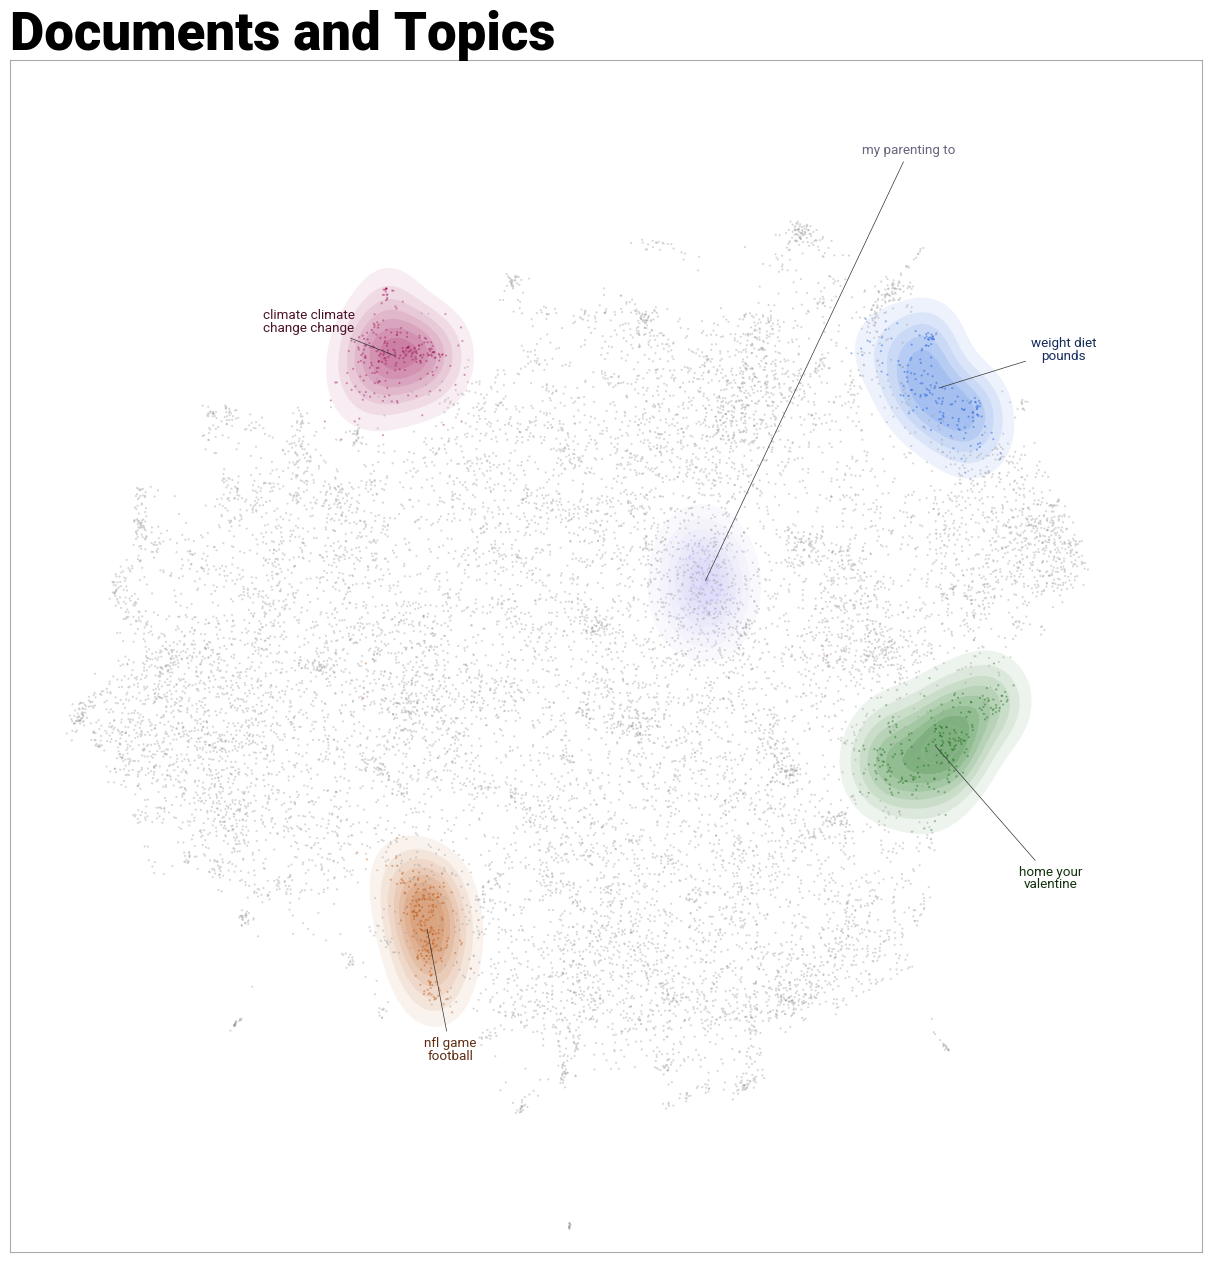

In [41]:
# Visualize the document datamap for a subset of topics
fig = topic_model.visualize_document_datamap(
    docs,                           # List of documents to visualize
    topics=list(range(5, 10)),
    width=1200,                     # Width of the figure in pixels
    height=1200,                    # Height of the figure in pixels
)

fig.show()

#### World Cloud

To begin, we should ensure that each topic is characterized by more than just 10 words, so that the resulting word clouds become richer and more informative.

In [38]:
# Update the topics in the BERTopic model
# Use the top 500 words per topic to refine topic representation
topic_model.update_topics(docs, top_n_words=500)

2025-12-22 12:50:07,025 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


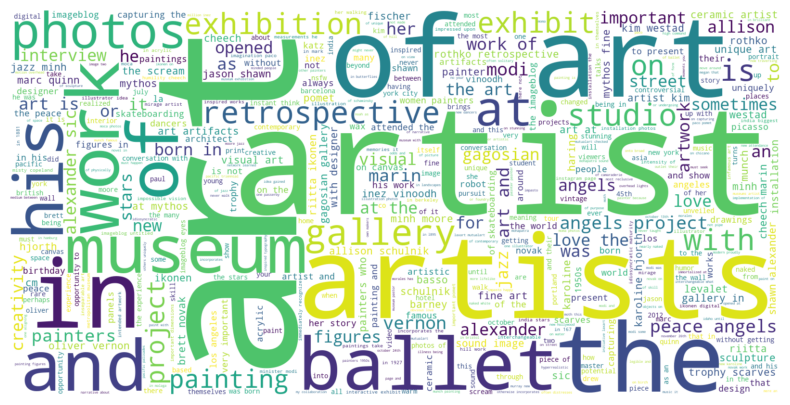

In [39]:
from wordcloud import WordCloud

# Select the topic ID to visualize
topic_id = 28

# Get the topic words and their importance scores
topic_words = {word: value for word, value in topic_model.get_topic(topic_id)}

# Create the WordCloud object
wc = WordCloud(
    background_color="white",  # White background
    max_words=1000,            # Maximum number of words to display
    width=1600,                # Image width
    height=800                 # Image height
)

# Generate the word cloud from the topic's word frequencies
wc.generate_from_frequencies(topic_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()